In [18]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os

from torch import nn
from torchvision import transforms
from torchinfo import summary
from pathlib import Path

from modules import data_setup
from modules import engine
from modules import utils

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# setting up the training and validation directories
image_path = Path('chest_xray/')
train_dir = image_path / "train"
val_dir = image_path / "val"

In [11]:
# importing the pre-trained model and transform
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit_transforms = pretrained_vit_weights.transforms()

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

pretrained_vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
train_dataloader, val_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=val_dir,
                                                                               transform=pretrained_vit_transforms, 
                                                                               batch_size=32
                                                                              )

train_dataloader, val_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1a9f74865e0>,
 ['NORMAL', 'PNEUMONIA'])

In [13]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "trainable"],
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]          [1, 1000]                 True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]          [1, 768, 14, 14]          True
├─Encoder (encoder)                                          [1, 197, 768]             [1, 197, 768]             True
│    └─Dropout (dropout)                                     [1, 197, 768]             [1, 197, 768]             --
│    └─Sequential (layers)                                   [1, 197, 768]             [1, 197, 768]             True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             [1, 197, 768]             True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]             [1, 197, 768]             True
│    │    └─EncoderBlock (encoder_layer_2)           

In [14]:
for params in pretrained_vit.parameters():
    params.requires_grad = False
    
pretrained_vit.heads = nn.Sequential(nn.LayerNorm(normalized_shape=768), nn.Linear(in_features=768, out_features=1))

In [15]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "trainable"],
        row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]          [1, 1]                    Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]          [1, 768, 14, 14]          False
├─Encoder (encoder)                                          [1, 197, 768]             [1, 197, 768]             False
│    └─Dropout (dropout)                                     [1, 197, 768]             [1, 197, 768]             --
│    └─Sequential (layers)                                   [1, 197, 768]             [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]             [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_2)   

In [16]:
# Training the model
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(pretrained_vit.parameters(), lr=3e-3)

results = engine.train(model=pretrained_vit, 
                       train_dataloader=train_dataloader, 
                       test_dataloader=val_dataloader, 
                       epochs=3, 
                       device=device, 
                       loss_fn=loss_fn, 
                       optimizer=optimizer
                      )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1563 | train_acc: 0.9346 | test_loss: 0.4971 | test_acc: 0.7500
Epoch: 2 | train_loss: 0.0904 | train_acc: 0.9651 | test_loss: 0.2994 | test_acc: 0.8750
Epoch: 3 | train_loss: 0.0733 | train_acc: 0.9724 | test_loss: 0.4238 | test_acc: 0.8125


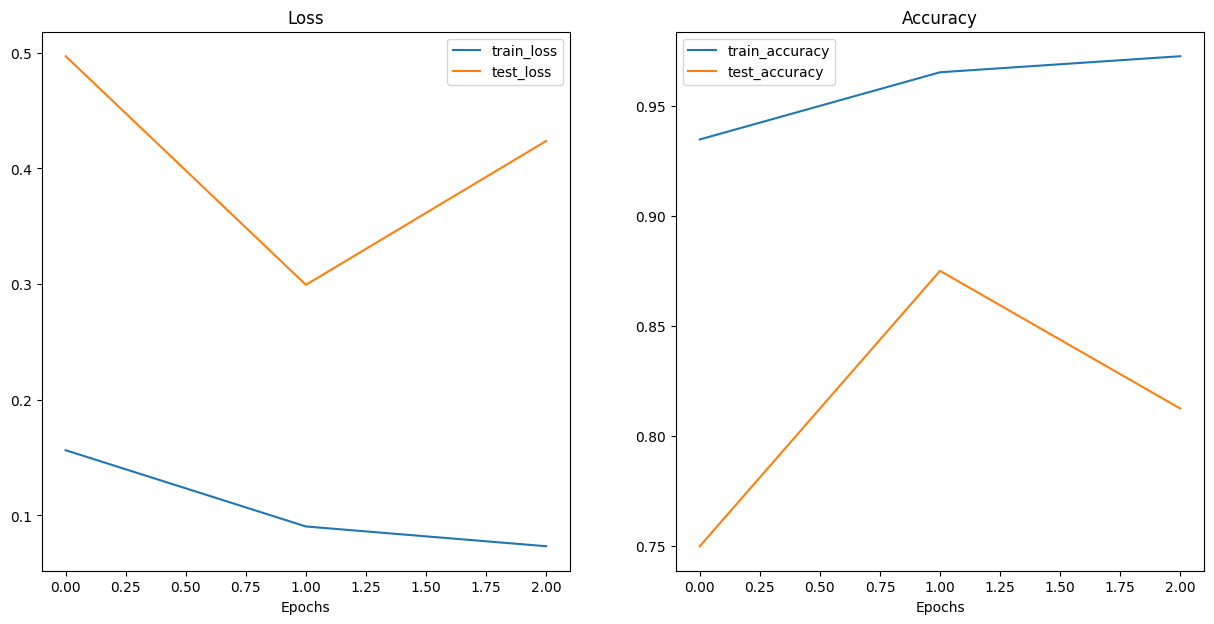

In [17]:
utils.plot_loss_curves(results)

In [26]:
model_dir = Path("models")
model_name = "finetuned_vit_b_16_pneumonia_feature_extractor.pth"

if not model_dir.exists():
    print(f"{model_dir} directory not found, creating directory")
    os.mkdir(model_dir)
    print(f"saving the model as {model_name}")
    torch.save(pretrained_vit.state_dict(), "models/"+model_name)
else:
    print(f"{model_dir} directory found, saving the model as {model_name}")
    torch.save(pretrained_vit.state_dict(), "models/"+model_name)

models directory found, saving the model as finetuned_vit_b_16_pneumonia_feature_extractor.pth


In [27]:
dict = torch.load(model_dir/model_name)

In [28]:
pretrained_vit.load_state_dict(torch.load("models/finetuned_vit_b_16_pneumonia_feature_extractor.pth"))

<All keys matched successfully>